In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Download latest version
path = kagglehub.dataset_download("sonia22222/students-mental-health-assessments")
print("Path to dataset files:", path)
dataset_files = [file for file in os.listdir(path) if file.endswith(".csv")]

# Load the first CSV file found into a Pandas DataFrame
if dataset_files:
    main_dataset_file = os.path.join(path, dataset_files[0])
    df = pd.read_csv(main_dataset_file)
    print("Main dataset loaded successfully into DataFrame.")
else:
    print("No CSV files found in the dataset path.")

# Display the first few rows of the DataFrame to confirm loading
print(df.head())

#Data Overview
print("\nData Overview:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe(include='all'))

#Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

100%|██████████| 101k/101k [00:00<00:00, 34.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sonia22222/students-mental-health-assessments/versions/4


Main dataset loaded successfully into DataFrame.
   Age            Course  Gender  CGPA  Stress_Level  Depression_Score  \
0   25            Others    Male  3.56             3                 3   
1   24       Engineering  Female  2.44             0                 3   
2   19          Business  Female  3.74             4                 0   
3   19  Computer Science    Male  3.65             2                 1   
4   18          Business    Male  3.40             3                 3   

   Anxiety_Score Sleep_Quality Physical_Activity Diet_Quality Social_Support  \
0              2          Good          Moderate         Good       Moderate   
1              0       Average               Low      Average            Low   
2              3          Good               Low      Average       Moderate   
3              0       Average               Low      Average       Moderate   
4              4          Good               Low      Average           High   

  Relationship_Status Sub

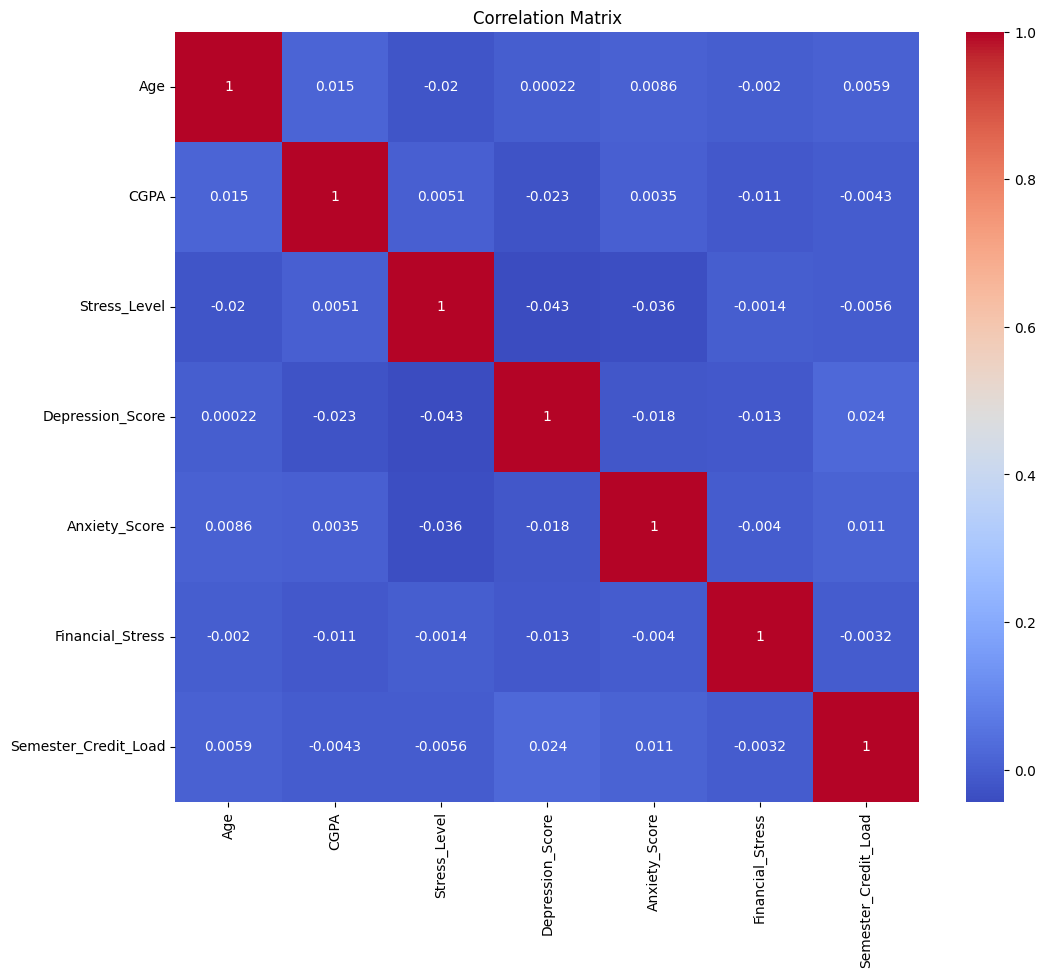

In [2]:
# Correlation matrix (for numerical features)
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [3]:
df.columns

Index(['Age', 'Course', 'Gender', 'CGPA', 'Stress_Level', 'Depression_Score',
       'Anxiety_Score', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality',
       'Social_Support', 'Relationship_Status', 'Substance_Use',
       'Counseling_Service_Use', 'Family_History', 'Chronic_Illness',
       'Financial_Stress', 'Extracurricular_Involvement',
       'Semester_Credit_Load', 'Residence_Type'],
      dtype='object')

In [4]:
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values)

# Remove rows with any missing values
df = df.dropna()

# Verify that there are no more missing values
print("\nMissing Values after removal:")
print(df.isnull().sum())



Missing Values:
Age                             0
Course                          0
Gender                          0
CGPA                           12
Stress_Level                    0
Depression_Score                0
Anxiety_Score                   0
Sleep_Quality                   0
Physical_Activity               0
Diet_Quality                    0
Social_Support                  0
Relationship_Status             0
Substance_Use                  15
Counseling_Service_Use          0
Family_History                  0
Chronic_Illness                 0
Financial_Stress                0
Extracurricular_Involvement     0
Semester_Credit_Load            0
Residence_Type                  0
dtype: int64

Missing Values after removal:
Age                            0
Course                         0
Gender                         0
CGPA                           0
Stress_Level                   0
Depression_Score               0
Anxiety_Score                  0
Sleep_Quality               

In [5]:
!pip install --upgrade tensorflow

In [6]:
pip install scikeras

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier  # Updated import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Feature Selection
features = [
    'Age', 'Course', 'Gender', 'CGPA', 'Sleep_Quality',
    'Physical_Activity', 'Diet_Quality', 'Social_Support',
    'Relationship_Status', 'Substance_Use', 'Counseling_Service_Use',
    'Family_History', 'Chronic_Illness', 'Financial_Stress',
    'Extracurricular_Involvement', 'Semester_Credit_Load',
    'Residence_Type']

X = df[features]
y = df['Stress_Level']

# One-hot encode categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(exclude=['object', 'category']).columns
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features),('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Encoding and binning the target variable
y = y.apply(lambda x: 0 if x <= 2 else 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define pipelines with model-specific preprocessing
pipelines = {
    'Logistic Regression': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'SVM': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('classifier', SVC(probability=True))
    ]),
}

# Generate logarithmically spaced C values
C_values = np.logspace(-20, 3, num=100)

# Parameters for grid search (hyperparameter optimization)
parameters = {
    'Logistic Regression': {
        'classifier__C': C_values,  # Regularization strength with log-spaced values
        'classifier__solver': ['liblinear', 'lbfgs', 'saga'],  # Optimization algorithms
        'classifier__penalty': ['l2', 'l1'],  # Regularization type
        'classifier__max_iter': [3000],  # Max iterations for convergence
    },

    'SVM': {
        'classifier__C': [0.1, 1, 10],  # Regularization strength with log-spaced values
        'classifier__kernel': ['linear', 'rbf'],      # Kernels to evaluate
        'classifier__gamma': ['scale', 'auto'],       # Kernel coefficient for RBF
        'classifier__degree': [3, 4, 5],              # Degree of polynomial kernel (only for polynomial kernel)
    },
}

# Define the 10-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV to find best hyperparameters for each model
best_params = {}

for name, pipeline in pipelines.items():
    print(f"\n--- Grid Search for {name} ---")

    # Initialize grid search
    grid_search = GridSearchCV(pipeline, parameters[name], cv=cv, n_jobs=-1, scoring='accuracy', verbose=3)

    # Fit the grid search model
    grid_search.fit(X_train, y_train)

    # Store best parameters for the model
    best_params[name] = grid_search.best_params_
    print(f"Best parameters for {name}: {best_params[name]}")


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)



--- Grid Search for Logistic Regression ---
Fitting 5 folds for each of 600 candidates, totalling 3000 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
500 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, 

Best parameters for Logistic Regression: {'classifier__C': 0.06579332246575656, 'classifier__max_iter': 3000, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

--- Grid Search for SVM ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for SVM: {'classifier__C': 0.1, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}



--- Evaluating Logistic Regression on Test Set ---
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.60      0.81      0.69      1078
           1       0.68      0.42      0.52      1021

    accuracy                           0.62      2099
   macro avg       0.64      0.62      0.60      2099
weighted avg       0.64      0.62      0.61      2099



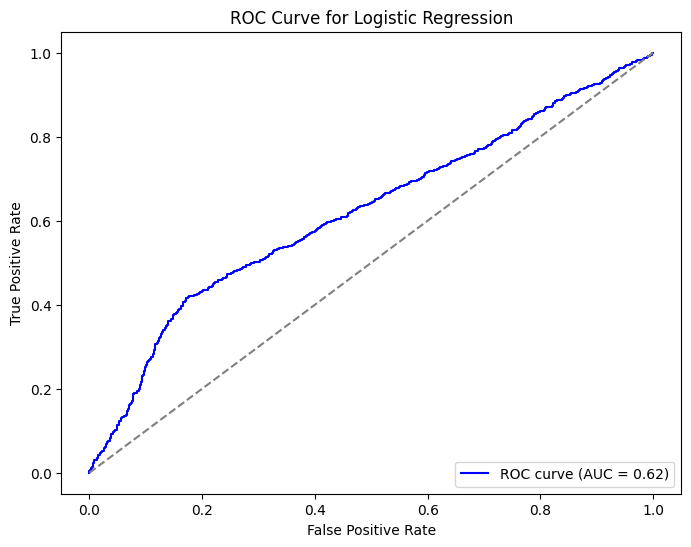

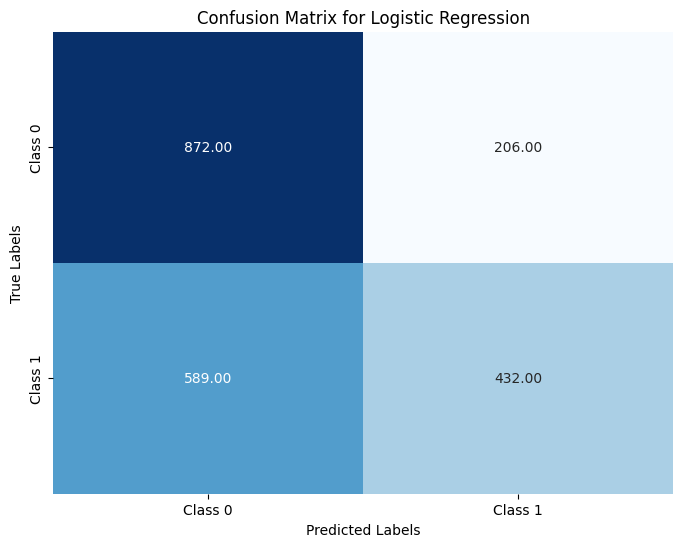


--- Evaluating SVM on Test Set ---
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.60      0.83      0.70      1078
           1       0.70      0.41      0.52      1021

    accuracy                           0.63      2099
   macro avg       0.65      0.62      0.61      2099
weighted avg       0.65      0.63      0.61      2099



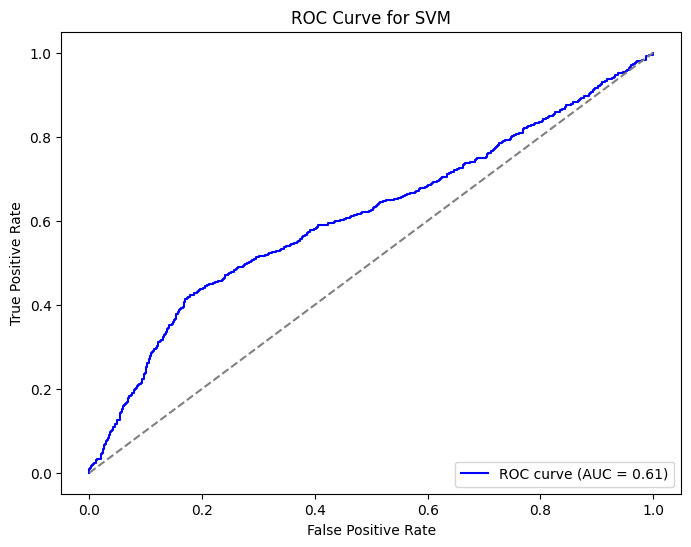

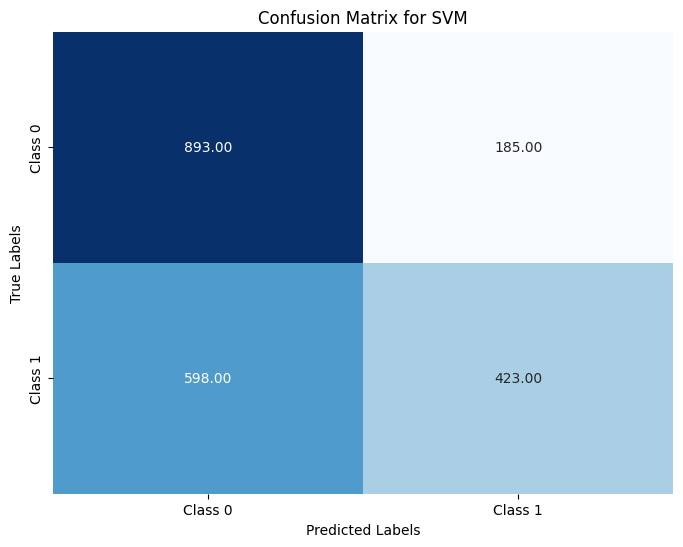

In [8]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve the best parameters from Block 1
best_logreg = best_params['Logistic Regression']
best_svm = best_params['SVM']

# Define final models with the best parameters
final_models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('classifier', LogisticRegression(max_iter=1000, C=best_logreg['classifier__C']))
    ]),
    'SVM': Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])),
        ('classifier', SVC(C=best_svm['classifier__C'], kernel=best_svm['classifier__kernel'], probability=True))
    ]),
}

# Evaluate models on the test set
for name, model in final_models.items():
    print(f"\n--- Evaluating {name} on Test Set ---")

    # Fit the model on the full training set and predict on the test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

    # Metrics: Classification Report
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'ROC Curve for {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()